<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">
*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

*No changes were made to the contents of this notebook from the original.*

<!--NAVIGATION-->
< [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb) | [Contents](Index.ipynb) | [Comparisons, Masks, and Boolean Logic](02.06-Boolean-Arrays-and-Masks.ipynb) >

# Computation on Arrays: Broadcasting

We saw in the previous section how NumPy's universal functions can be used to *vectorize* operations and thereby remove slow Python loops.
Another means of vectorizing operations is to use NumPy's *broadcasting* functionality.
Broadcasting is simply a set of rules for applying binary ufuncs (e.g., addition, subtraction, multiplication, etc.) on arrays of different sizes.

## Introducing Broadcasting

Recall that for arrays of the same size, binary operations are performed on an element-by-element basis:

In [1]:
import numpy as np

In [2]:
a = np.array([0, 1, 2])
b = np.array([5, 5, 5])
a + b

array([5, 6, 7])

Broadcasting allows these types of binary operations to be performed on arrays of different sizes–for example, we can just as easily add a scalar (think of it as a zero-dimensional array) to an array:

In [3]:
a + 5

array([5, 6, 7])

We can think of this as an operation that stretches or duplicates the value ``5`` into the array ``[5, 5, 5]``, and adds the results.
The advantage of NumPy's broadcasting is that this duplication of values does not actually take place, but it is a useful mental model as we think about broadcasting.

We can similarly extend this to arrays of higher dimension. Observe the result when we add a one-dimensional array to a two-dimensional array:

In [4]:
M = np.ones((3, 3))
M

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [5]:
M + a

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

Here the one-dimensional array ``a`` is stretched, or broadcast across the second dimension in order to match the shape of ``M``.

While these examples are relatively easy to understand, more complicated cases can involve broadcasting of both arrays. Consider the following example:

In [6]:
a = np.arange(3)
b = np.arange(3)[:, np.newaxis]

print(a)
print(b)

[0 1 2]
[[0]
 [1]
 [2]]


In [7]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

Just as before we stretched or broadcasted one value to match the shape of the other, here we've stretched *both* ``a`` and ``b`` to match a common shape, and the result is a two-dimensional array!
The geometry of these examples is visualized in the following figure (Code to produce this plot can be found in the [appendix](06.00-Figure-Code.ipynb#Broadcasting), and is adapted from source published in the [astroML](http://astroml.org) documentation. Used by permission).

![Broadcasting Visual](figures/02.05-broadcasting.png)

The light boxes represent the broadcasted values: again, this extra memory is not actually allocated in the course of the operation, but it can be useful conceptually to imagine that it is.

## Rules of Broadcasting

Broadcasting in NumPy follows a strict set of rules to determine the interaction between the two arrays:

- Rule 1: If the two arrays differ in their number of dimensions, the shape of the one with fewer dimensions is **padded** with ones on its leading (left) side.
- Rule 2: If the shape of the two arrays does not match in any dimension, the array with shape equal to 1 in that dimension is **stretched** to match the other shape.
- Rule 3: If in any dimension the sizes disagree and neither is equal to 1, an error is raised.

To make these rules clear, let's consider a few examples in detail.

### Broadcasting example 1

Let's look at adding a two-dimensional array to a one-dimensional array:

In [8]:
M = np.ones((2, 3))
a = np.arange(3)

Let's consider an operation on these two arrays. The shape of the arrays are

- ``M.shape = (2, 3)``
- ``a.shape = (3,)``

We see by rule 1 that the array ``a`` has fewer dimensions, so we pad it on the left with ones:

- ``M.shape -> (2, 3)``
- ``a.shape -> (1, 3)``

By rule 2, we now see that the first dimension disagrees, so we stretch this dimension to match:

- ``M.shape -> (2, 3)``
- ``a.shape -> (2, 3)``

The shapes match, and we see that the final shape will be ``(2, 3)``:

In [9]:
M + a

array([[1., 2., 3.],
       [1., 2., 3.]])

### Broadcasting example 2

Let's take a look at an example where both arrays need to be broadcast:

In [10]:
a = np.arange(3).reshape((3, 1))
b = np.arange(3)

Again, we'll start by writing out the shape of the arrays:

- ``a.shape = (3, 1)``
- ``b.shape = (3,)``

Rule 1 says we must pad the shape of ``b`` with ones:

- ``a.shape -> (3, 1)``
- ``b.shape -> (1, 3)``

And rule 2 tells us that we upgrade each of these ones to match the corresponding size of the other array:

- ``a.shape -> (3, 3)``
- ``b.shape -> (3, 3)``

Because the result matches, these shapes are compatible. We can see this here:

In [11]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

### Broadcasting example 3

Now let's take a look at an example in which the two arrays are not compatible:

In [12]:
M = np.ones((3, 2))
a = np.arange(3)

This is just a slightly different situation than in the first example: the matrix ``M`` is transposed.
How does this affect the calculation? The shape of the arrays are

- ``M.shape = (3, 2)``
- ``a.shape = (3,)``

Again, rule 1 tells us that we must pad the shape of ``a`` with ones:

- ``M.shape -> (3, 2)``
- ``a.shape -> (1, 3)``

By rule 2, the first dimension of ``a`` is stretched to match that of ``M``:

- ``M.shape -> (3, 2)``
- ``a.shape -> (3, 3)``

Now we hit rule 3–the final shapes do not match, so these two arrays are incompatible, as we can observe by attempting this operation:

In [13]:
M + a

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

Note the potential confusion here: you could imagine making ``a`` and ``M`` compatible by, say, padding ``a``'s shape with ones on the right rather than the left.
But this is not how the broadcasting rules work!
That sort of flexibility might be useful in some cases, but it would lead to potential areas of ambiguity.
If right-side padding is what you'd like, you can do this explicitly by reshaping the array (we'll use the ``np.newaxis`` keyword introduced in [The Basics of NumPy Arrays](02.02-The-Basics-Of-NumPy-Arrays.ipynb)):

In [14]:
a[:, np.newaxis].shape

(3, 1)

In [15]:
M + a[:, np.newaxis]

array([[1., 1.],
       [2., 2.],
       [3., 3.]])

Also note that while we've been focusing on the ``+`` operator here, these broadcasting rules apply to *any* binary ``ufunc``.
For example, here is the ``logaddexp(a, b)`` function, which computes ``log(exp(a) + exp(b))`` with more precision than the naive approach:

In [16]:
np.logaddexp(M, a[:, np.newaxis])

array([[1.31326169, 1.31326169],
       [1.69314718, 1.69314718],
       [2.31326169, 2.31326169]])

For more information on the many available universal functions, refer to [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb).

## Broadcasting in Practice

Broadcasting operations form the core of many examples we'll see throughout this book.
We'll now take a look at a couple simple examples of where they can be useful.

### Centering an array

In the previous section, we saw that ufuncs allow a NumPy user to remove the need to explicitly write slow Python loops. Broadcasting extends this ability.
One commonly seen example is when centering an array of data.
Imagine you have an array of 10 observations, each of which consists of 3 values.
Using the standard convention (see [Data Representation in Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb#Data-Representation-in-Scikit-Learn)), we'll store this in a $10 \times 3$ array:

In [17]:
X = np.random.random((10, 3))

We can compute the mean of each feature using the ``mean`` aggregate across the first dimension:

In [18]:
Xmean = X.mean(0)
Xmean

array([0.29352138, 0.41782419, 0.54703443])

And now we can center the ``X`` array by subtracting the mean (this is a broadcasting operation):

In [19]:
X_centered = X - Xmean

To double-check that we've done this correctly, we can check that the centered array has near zero mean:

In [20]:
X_centered.mean(0)

array([3.33066907e-17, 3.88578059e-17, 2.22044605e-17])

To within machine precision, the mean is now zero.

### Plotting a two-dimensional function

One place that broadcasting is very useful is in displaying images based on two-dimensional functions.
If we want to define a function $z = f(x, y)$, broadcasting can be used to compute the function across the grid:

In [21]:
# x and y have 50 steps from 0 to 5
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)[:, np.newaxis]

z = np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

We'll use Matplotlib to plot this two-dimensional array (these tools will be discussed in full in [Density and Contour Plots](04.04-Density-and-Contour-Plots.ipynb)):

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

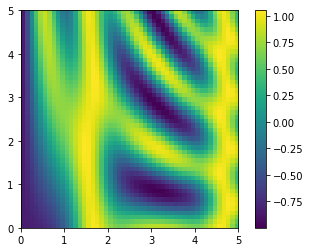

In [23]:
plt.imshow(z, origin='lower', extent=[0, 5, 0, 5],
           cmap='viridis')
plt.colorbar();

The result is a compelling visualization of the two-dimensional function.

<!--NAVIGATION-->
< [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb) | [Contents](Index.ipynb) | [Comparisons, Masks, and Boolean Logic](02.06-Boolean-Arrays-and-Masks.ipynb) >